In [351]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import sklearn.datasets

def prepare_swissroll_data(BATCH_SIZE=1000):
    ''' This is derived from https://github.com/lukovnikov/improved_wgan_training/blob/master/gan_toy.py
         Copyright (c) 2017 Ishaan Gulrajani
         Released under the MIT license
         https://github.com/lukovnikov/improved_wgan_training/blob/master/LICENSE '''
    data = sklearn.datasets.make_swiss_roll(
                    n_samples=BATCH_SIZE,
                    noise=0.25
                )[0]
    data = data.astype('float32')[:, [0, 2]]
    data /= 2#7.5 # stdev plus a little
    return data

def plot_2d_data(X, title=None, ax=None, ax2=None, f=None):
    if ax is None:
        if f is not None:
            fig = plt.figure(figsize=(5,10))
            ax = fig.add_subplot(2,1,1)
            ax2 = fig.add_subplot(2,1,2)
        else:
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(1,1,1)
    
    if title is not None:
        ax.set_title(title, fontsize=20)
        
    #ax.set_xlim(-1.6, 2.0); ax.set_ylim(-1.7, 2.1)
    ax.scatter(X[:,0], X[:,1], alpha=0.5)
    if f is not None:
        sample_size=1000
        Z = tf.random.normal(shape=(sample_size, f.dim_Z))
        x_fake = f(Z)
        #ax.set_title("X", fontsize=20)
        ax.scatter(x_fake[:,0], x_fake[:,1], marker='.', alpha=0.5, color='red', label='f(z)')
        lgd = ax.legend(fontsize=20, loc='upper left')
        for text in lgd.get_texts():
            text.set_color("red")
        ax2.set_xlim(-3, 3); ax2.set_ylim(-3, 3)
        ax2.set_title("Z", fontsize=20)
        ax2.scatter(Z[:,0], Z[:,1], marker='.', alpha=0.5, color='red')
        z, _ = f.inv(X)
        ax2.scatter(z[:,0], z[:,1], alpha=0.5,color='C0', label='f.inv(x)')   
        lgd = ax2.legend(fontsize=20, loc='upper left')
        for text in lgd.get_texts():
            text.set_color("C0")

## 8-3. Flow-based モデル
これまで VAE, GANの２つを紹介しましたが、
* 訓練に二種類のネットワークを必要とする
* 対数尤度 $- \log p_\theta(x)$ を用いることができない

点が共通していました。ところで、GANのようなモデル

$$
p_\theta(x)=
\int dz  \ \delta(x - f_\theta(z)) p_Z(z)
$$

を考えたとき、もし $x$ と $z$ の次元が等しく、かつ $f_\theta^{-1}$ が存在したとすると、上の $z$ 積分は

$$
\left. \begin{array}{ll}
p_\theta(x)= &= \int \det \frac{\partial f_\theta^{-1}(y)}{\partial y} dy  \ \delta(x - y) p_Z(f_\theta^{-1}(y))
\\
&= \Big|\det \frac{\partial f_\theta^{-1}(x)}{\partial x}\Big| \cdot p_Z(f_\theta^{-1}(x))
\end{array} \right.
$$

のように実行できます。これは、**可逆なニューラルネット** として $f_\theta$ を作ることが出来れば、VAEやGANのような間接的な目的関数でなく、

$$
- \log p_\theta(x) = - \log p_Z(f_\theta^{-1}(x)) - \log \Big|\det \frac{\partial f_\theta^{-1}(x)}{\partial x}\Big|
$$

を直接誤差関数にした教師なし学習が可能であることを意味します。

ここでは [arXiv:1605.08803](https://arxiv.org/abs/1605.08803) に基づき、**real-valued non-volume preserving (real NVP) 変換** と呼ばれる変換に基づいたニューラルネット構成を実践してみたいと思います。

#### Coupling layer
ニューラルネットを可逆にするためには各層の変換を可逆にせねばなりません。real NVPのカップリング層と呼ばれるレイヤーでは、入力ベクトル $z$ を
* ~$d-1$番目成分 $z_{-:d}$
* $d$番目成分~ $z_{d:-}$

にわけ、前者については何もせず $x_{-:d} = z_{-:d}$ 、後者については、以下の変換をかけます：

$$
x_{d:-} = z_{d:-}\odot\exp\big( s(z_{-:d}) \big) +  t(z_{-:d})
$$

ここで $s, t$ は $z_{d:-}$ と同じ次元のベクトル値関数で、何でも良いです。また $\odot$ は成分毎の積を意味するとします。この変換：

$$
\left( \begin{array}{ll}
x_{-:d}
\\
x_{d:-}
\end{array} \right) =
\begin{pmatrix}
z_{-:d} \\
z_{d:-}\odot\exp\big( s(z_{-:d}) \big) +  t(z_{-:d})
\end{pmatrix}
$$

は逆変換

$$
\left( \begin{array}{ll}
x_{-:d}
\\
\big( x_{d:-} -  t(x_{-:d}) \big)\odot\exp\big( - s(x_{-:d}) \big) 
\end{array} \right) =
\begin{pmatrix}
z_{-:d} \\
z_{d:-}
\end{pmatrix}
$$

を持つのがわかります。また、ヤコビアンも計算でき

$$
\det \frac{\partial x}{\partial z} = \det
\begin{pmatrix}
1 & 0 \\
* & \exp\big( s(z_{-:d}) \big) 
\end{pmatrix} = \prod_{i>d}\exp\big( s(z_{-:d}) \big)_i
$$

となります。特にこのlogは

$$
\log\det \frac{\partial x}{\partial z} =  \sum_{i>d} s(z_{-:d})_i
$$

となります。s,tは任意関数でいいのですが、とりあえずここでは3層ニューラルネットにしておきます：


In [386]:
class DenseCoupling(tf.keras.layers.Layer):
    def __init__(self, d, kernel_initializer):
        super(DenseCoupling, self).__init__()
        self.d = d
        self.init = kernel_initializer
        self.s = tf.keras.models.Sequential([tf.keras.layers.Dense(32, activation='relu'),
                                             tf.keras.layers.Dense(32, activation='relu'),
                                             tf.keras.layers.Dense(1, activation='tanh')])
                                             
        self.t = tf.keras.models.Sequential([tf.keras.layers.Dense(32, activation='relu'),
                                             tf.keras.layers.Dense(32, activation='relu'),
                                             tf.keras.layers.Dense(1, activation='tanh')])
        
    def call(self, z, logdet):
        z0 = z[:,:self.d]
        z1 = z[:,self.d:]
        
        s = self.s(z0)
        t = self.t(z0)
        
        x0 = z0
        x1 = z1*tf.exp(s) + t
        
        x = tf.concat([x0, x1], axis=1)
        return x, logdet + tf.reduce_sum(s, axis=1)
    
    def inv(self, x, logdet):
        x0 = x[:,:self.d]
        x1 = x[:,self.d:]
        
        s = self.s(x0)
        t = self.t(x0)
        
        z0 = x0
        z1 = (x1 - t)*tf.exp(-s)
        
        z = tf.concat([z0, z1], axis=1)
        return z, logdet + tf.reduce_sum(-s, axis=1)

念の為きちんと逆変換が実装できているか確認しておきます：

In [393]:
x0 = X_2d[1:2]
d = DenseCoupling(1, kernel_initializer=None)
z, ld = d.inv(x0, 0)
x, _ = d(z, 0)
x0==x

<tf.Tensor: shape=(1, 2), dtype=bool, numpy=array([[ True,  True]])>

#### Composition
これだけでは初めの $d$ 成分は恒等変換を受けるばかりなので、論文にあるように、$z_{-:d}$ と $z_{d:-}$ を入れ替えるような層も作っておきます。これは

$$
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
$$

のような線形変換で実現できるので、常に定数のdeterminantを返します。定数determinantは訓練で不要なので略します：

In [388]:
def alternate(z, d=1):
    ''' z=[z0, z1] -> [z1, z0] '''
    z0 = z[:,:d]
    z1 = z[:,d:]
        
    z = tf.concat([z1, z0], axis=1)
    return z

#### 全体像
カップリングを $f_W$, 入れ替えを $a$ とでも表し、この操作の繰り返し

$$
f_\theta (z) = f_{W_1}\circ a \circ f_{W_2} \circ a \circ \cdots \circ a \circ f_{W_N}(z)
$$

を考えると、逆変換は

$$
f_\theta^{-1} (x) = f_{W_N}^{-1}\circ a \circ \cdots \circ a \circ f_{W_2}^{-1} \circ a \circ f_{W_1}^{-1}(x)
$$

で表せます。このとき、連鎖律からヤコビアンのlogは

$$
\log \det \frac{\partial f_\theta^{-1}(x)}{\partial x} = \sum_{n=1}^N \log \det \nabla f_{W_n}^{-1} 
$$

のように、各 $f_{W_i}^{-1}$ のlog行列式の和（と$a$ からくる定数）から成ります。Coupling層の`call`と`inv`で、それぞれ $f, f^{-1}$ の出力と、各logdetの出力を実装しておいたので、実際にはCoupling層で`inv`を使う際に logdet も拾うようにして、最後の勾配更新の考慮に入れるようにしておけばOKです。

最後に目的関数の1項目 $-\log p_Z(f_\theta^{-1}(x))$ を計算するには、潜在空間上の確率密度関数を定める必要があります。簡単のため標準正規分布にすると、

$$
- \log p_Z(z) = \frac{z^2}{2}
$$

ですので、この部分は二乗誤差でよいでしょう。つまり、



In [380]:
def NLL(z, logdet):
    logpz = tf.norm(z, axis=1)**2/2
    #print(logpz, logdet)
    return tf.reduce_mean(logpz -logdet) + tf.math.log(2*3.141592)

で負の対数尤度を計算できていることになります。

#### 訓練ステップ
あとは
* データ $x$ サンプリング
* $x \to z, \log \det$ をニューラルネットで出力
* `NLL(z, logdet)` を loss として勾配更新

とすればよいはずです：

In [381]:
def update(X, f, opt):
    sample_size = X.shape[0]
    with tf.GradientTape() as tape:
        z, logdet = f.inv(X)
        loss = NLL(z, logdet)
    grads = tape.gradient(loss, f.trainable_variables)
    opt.apply_gradients(zip(grads, f.trainable_variables))
    return loss

### 2次元で real NVP
以下のように $X$ を実2次元空間として、その上にスイスロール状に分布したデータを教師なしデータとして、real NVPを訓練してみましょう。

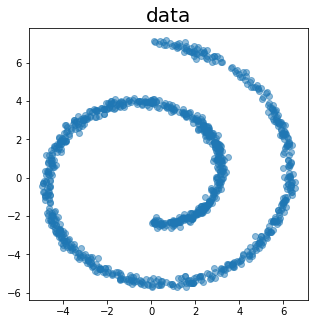

In [382]:
X_2d = prepare_swissroll_data() # 出力はnumpy.array
plot_2d_data(X_2d, title='data'); plt.show()

#### model
以下のように、
* `call`: $z \to x$ 方向
* `inv`: $x \to z$ 方向

として実装しておきます。

In [389]:
class Flow(tf.keras.Model):
    def __init__(self, dim_Z=2, L=10):
        ''' self.couplings というリストに DenseCoupling層 を L 回入れる '''
        super(Flow, self).__init__()
        initializer = tf.initializers.he_normal()
        self.couplings = []
        for l in range(L):
            self.couplings.append(DenseCoupling(1, kernel_initializer=initializer))    
        self.dim_Z = dim_Z
        self.L = L

    def call(self, h):
        ''' self.couplings の順に呼び出し '''
        logdet = 0
        h = alternate(h)
        for C in self.couplings:
            h, logdet = C(h, logdet)
            h = alternate(h)
        return h
    
    def inv(self, h):
        ''' self.couplings の「逆」順に呼び出し '''
        logdet = 0
        h = alternate(h)
        for C in reversed(self.couplings):
            h, logdet = C.inv(h, logdet)
            h = alternate(h)
        return h, logdet
    
    def generate(self, sample_size):
        z = tf.random.normal(shape=(sample_size, self.dim_Z))
        return self(z)

#### Training
訓練中のテストは実際に2次元にプロットすることにします。

In [390]:
def train_2d(f, X_2d, batch_size, epochs=5):
    tf_update = tf.function(update)
    opt = tf.keras.optimizers.Adam(1e-4)
    Data = tf.data.Dataset.from_tensor_slices(X_2d)
    fig = plt.figure(figsize=(5*6,10))
    plotlabel = 1
    for epoch in range(epochs+1):
        batch = Data.shuffle(len(X_2d)).batch(batch_size, drop_remainder=True)
        for X in batch:
            loss = tf_update(X, f, opt)
        if epoch%(epochs//5)==0:
            # test
            print("L =", loss)
            ax = fig.add_subplot(2,6,plotlabel)
            ax2 = fig.add_subplot(2,6,plotlabel+6)
            plot_2d_data(X_2d, title="{}-epoch".format(epoch), f=f, ax=ax, ax2=ax2)
            plotlabel += 1
    plt.show()
    return f

以下の訓練は CPU でもそれなりに早く完了できます。テストでは
* 上段：データ空間、青色＝データ点、赤色＝$f$(潜在空間の赤点)
* 下段：潜在空間、青色＝$f^{-1}$(データ空間のデータ点)、赤色＝正規分布$p_z$からのサンプル

として表示しています。

L = tf.Tensor(63.121956, shape=(), dtype=float32)
L = tf.Tensor(4.5979877, shape=(), dtype=float32)
L = tf.Tensor(4.250997, shape=(), dtype=float32)
L = tf.Tensor(3.9169712, shape=(), dtype=float32)
L = tf.Tensor(3.5752122, shape=(), dtype=float32)
L = tf.Tensor(3.7270236, shape=(), dtype=float32)


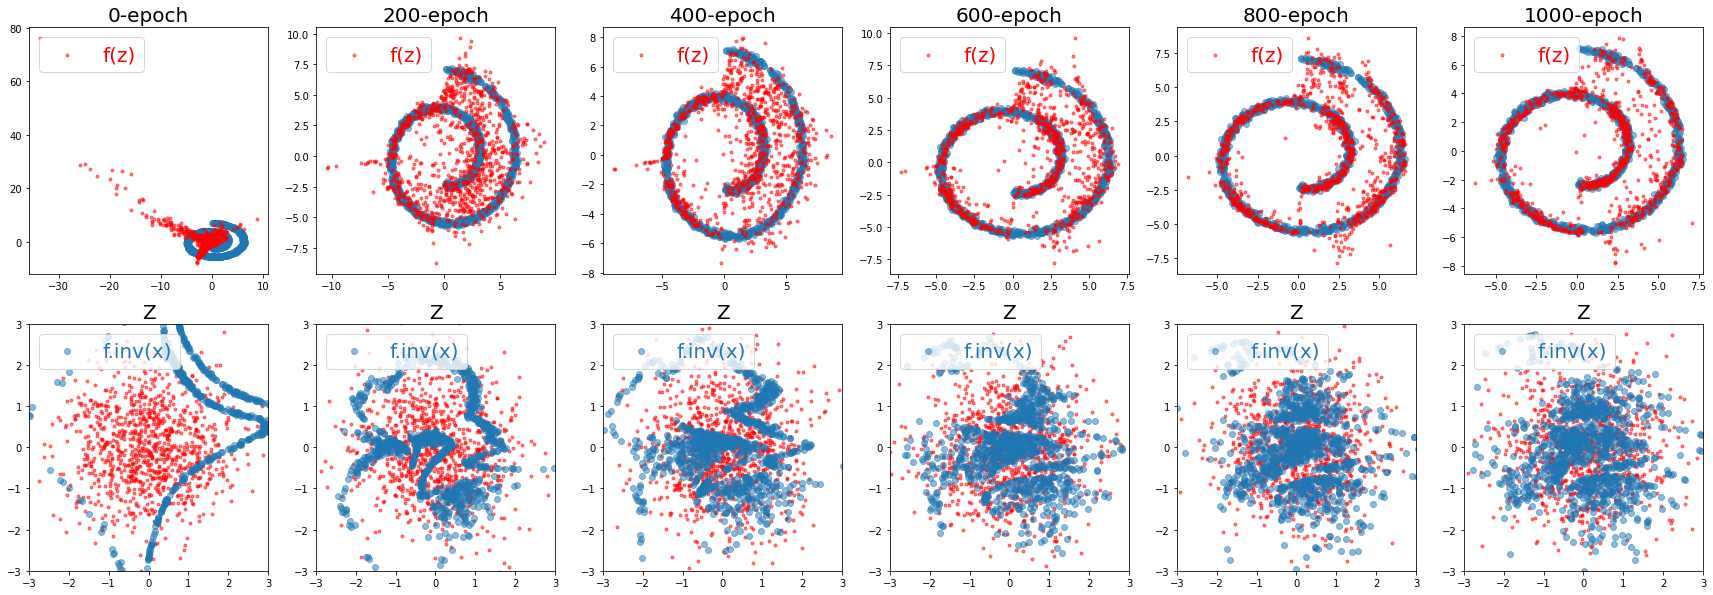

In [391]:
#%%time
f = Flow(L=20)
train_2d(f, X_2d, batch_size=128, epochs=1000)

このように、うまくいけば
* データ点 $\to p_z$ への埋め込み
* $p_z \to$ データ点への埋め込み

が互いにうまく達成されます。

### MNISTでreal NVP
to be constructed.

#### Licence in this subsection
In this notebook, the definitions of

* function: `prepare_swissroll_data`

includes codes derived from
https://github.com/lukovnikov/improved_wgan_training/blob/master/gan_toy.py
which is licenced as follows:
> Copyright (c) 2017 Ishaan Gulrajani <br>
> Released under the MIT license <br>
> https://github.com/lukovnikov/improved_wgan_training/blob/master/LICENSE